# The War Exchange

### Algorithm

To quantify the effect of shifting weights on playoff odds, we need a way to simulate entire seasons simply and quickly, with enough simulations to separate signal from noise. 
The simulation will be built around Python **Classes** for Teams and Seasons.  <br>

The details of how we define and apply "nudge's" makes all the difference.  Here we add 2\times the nudge factor for division rivals, 1\times the nudge factor for league rivals, and none for inter-league.  Furthermore, we normalize so that nudges are a zero-sum manipulation; i.e., to play better in some games, you have to give something up in others.   
<br>

Required data:
1. Lahman Database to estimate each teams true-talent [in sqlite from jknecht's Github](https://github.com/jknecht/baseball-archive-sqlite)
2. Retrosheet Schedule.  https://www.retrosheet.org/schedule/

Steps: 
1. Import a Schedule
2. Import Season Stats to Infer true-talent
3. Specify Simulation Details
4. Loop <br>
    a. Season Simulations <br>
    b. Determine Rankings
5. Analyze Outcomes

### Python packages
We start by importing some standard Python packages.  

In [1]:
# For mac users with Retina display
%config InlineBackend.figure_format = 'retina' 
# OS
import os, subprocess
import os.path
# Numpy
import numpy as np; print("  numpy:", np.__version__)
# Scipy
import scipy as sp; print("  scipy:", sp.__version__)
import scipy.stats as stats
from scipy.optimize import curve_fit
# Pandas 
import pandas as pd; print("  pandas:", pd.__version__)
# Seaborn is for improved plotting style
import seaborn as sns; print("  seaborn:", sns.__version__)
# Sci-kit Learn
import sklearn; print("  scikit-learn:", sklearn.__version__)
# SQL 
import sqlite3
# Python Debugger
import pdb

  numpy: 1.17.2
  scipy: 1.3.1
  pandas: 0.25.1
  seaborn: 0.9.0
  scikit-learn: 0.21.3


In [2]:
# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 8,
          'figure.figsize': (6, 6),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.style.use('seaborn') 
pylab.rcParams.update(params)
plt.rcParams['figure.dpi'] = 90 
%matplotlib inline

We use seaborn to improve the look of the figures, and matplotlib inline to see the figures in the cells.

### Tools   

#### Simulate Wins/Losses as weighted coin flip using the binomial distribution, where the mean is estimated using the win/loss records of the opposing teams.

In [3]:
def weighted_coin_flip(vt_truetalent, ht_truetalent, homefieldadv = 0.04, vt_nudge = 0.0, ht_nudge = 0.0, number_flips=1):
    ''' Estimate win or loss based on combination of true talent of both teams, and random chance. '''
    
    # Effective True Talent can be nudged up or down if say, starting pitcher is the ace, or sitting best players for rest.
    eff_ht = ht_truetalent * (1 + ht_nudge + homefieldadv);
    eff_vt = vt_truetalent * (1 + vt_nudge);

    # Combine effective weights (plus home field advantage) with team true talents to estimate effective probabililty.
    effective_weighted_probability = (eff_ht * (1 - eff_vt)) / ((eff_ht * (1 - eff_vt)) + (eff_vt * (1 - eff_ht)))

    # Return estimate of a binomial distribution with effective probability.  
    return np.random.binomial(1, effective_weighted_probability, number_flips)

#### Determine Standings for one season simulation, given schedule and previous records. 

In [4]:
def single_season_standings(schedule, seasons = 1):
    ''' 
    Input MLB Season Schedule and use weighted_coin_flip (a wrapper for the Binomial Distribution) to Estimate Wins/Losses.
    
    Returns dictionary matchups, which for each team contains an array with:
        0 - date
        1 - visiting team (vt)
        2 - home team (ht)
        3 - home team outcome (win = 1, loss = 0)
    for each game in the season.
    '''   
    
    # Dictionary to store matchups.
    matchups = {}
    
    # Assume a 4% home field advantage 
    home_field_advantage = 0.04 
    
    # Loop over every game in schedule. 
    for index in range(len(schedule.matchups)):

        # Extract row
        row = schedule.matchups.iloc[index]
        date = row.date
        
        # Store visiting and home team ID
        vt = row.vt
        ht = row.ht
        
        # Use real data to estimate their true talent.  
        vt_truetalent = schedule.wins[row.vt] / 162. 
        ht_truetalent = schedule.wins[row.ht] / 162. 
        
        # Extract nudge values from schedule.
        vt_nudge = row.vt_nudge
        ht_nudge = row.ht_nudge
        
        # Estimate game-winner based on true-talent + nudges.  
        ht_win = weighted_coin_flip(vt_truetalent, ht_truetalent, home_field_advantage, vt_nudge = vt_nudge, ht_nudge = ht_nudge, number_flips=seasons)
        
        # Store results in matchups
        if ht in matchups.keys():
            matchups[ht] = matchups[ht].append(pd.DataFrame([[date, vt, ht, ht_win]], columns = ['date','visiting_team','home_team', 'win']))
        else:
            matchups[ht] = pd.DataFrame([[date, vt, ht, ht_win]], columns = ['date','visiting_team','home_team', 'win'])
            
        if vt in matchups.keys():
            matchups[vt] = matchups[vt].append(pd.DataFrame([[date, vt, ht, abs(1 - ht_win)]], columns = ['date','visiting_team','home_team', 'win']))
        else:
            matchups[vt] = pd.DataFrame([[date, vt, ht, abs(1 - ht_win)]], columns = ['date','visiting_team','home_team', 'win'])
    
    return matchups

#### Determine schedule, and implement nudge factors based on specified conditions, etc., if playing division rival, or inter-league.  

In [5]:
class team_schedules:
    '''Store Team Schedules and Nudge Values'''
    
    def __init__(self, sched_df):
        
        # Hard-code Leagues and Divisions 
        AL = {}
        NL = {}
        MLB = {"NL":NL,"AL":AL}
        AL['East']    = ['NYA','TOR','BOS','BAL','TBA']
        AL['Central'] = ['CHA','KCA','CLE','MIN','DET']
        AL['West']    = ['OAK','ANA','HOU','TEX','SEA']
        NL['East']    = ['NYN','ATL','MIA','WAS','PHI']
        NL['Central'] = ['CHN','MIL','CIN','PIT','SLN']
        NL['West']    = ['LAN','SDN','SFN','ARI','COL']
        self.leagues = MLB 
        self.teams = {"NL":np.unique(sched_df[sched_df.league_ht == 'NL'].ht), "AL":np.unique(sched_df[sched_df.league_ht == 'AL'].ht)}
        self.matchups = pd.DataFrame(columns = ['date','ht','vt','rivalry_level','ht_nudge','vt_nudge'])
        self.wins = {}

        # Store Schedules into Matchups DataFrame
        for league in self.leagues:
            for team in self.teams[league]:
                self.matchups = self.matchups.append(sched_df[sched_df.ht == team][['date','ht','vt']],sort=False)
        
        # Call Rivalry level setter (inter-division, etc.)
        self.define_rivalry_level()
        
    # Store Real-Life Wins for later estimate of true-talent
    def get_wins(self, ttt):
        for league in self.leagues:
            for team in self.teams[league]:
                self.wins[team] = ttt[ttt.teamID == team].W.values[0]
    
    # Set the Rivalry level (inter-division, etc.)
    def define_rivalry_level(self):
        '''Determine whether contest is inter-division (rivalry_level=2), inter-league (rivalry_level=1), or out of league (rivalry_level=0)'''
        for league in self.leagues:
            for team in self.teams[league]:
                idx_ht = self.matchups[self.matchups.ht == team].index
                for home_game_id in idx_ht:
                    rival = pd.DataFrame(self.leagues[league]).isin(self.matchups[['vt','ht']].loc[home_game_id].values)
                    self.matchups['rivalry_level'].loc[home_game_id] = rival.sum().max() + rival.sum().sum() - 2
    
    # Set the Nudge level.  
    def set_nudge_level(self, nudge_lvl, zero_sum = True):
        '''Set the nudge level by multiplication nudge_lvl and rivalry_level'''
        for team in nudge_lvl:
            for i, n in zip(['ht','vt'], ['ht_nudge','vt_nudge']):
                idx_tm = self.matchups[self.matchups[i] == team].index
                nudge_array = self.matchups.loc[idx_tm]['rivalry_level'] * nudge_lvl[team]
                if zero_sum == True:
                    self.matchups[n].loc[idx_tm] = (nudge_array - sum(nudge_array)/len(nudge_array))
                else:
                    self.matchups[n].loc[idx_tm] = nudge_array
        
        self.matchups = self.matchups.fillna(0)

#### Use sqlite and the Lahman database to get prior estimates of team records.  

In [6]:
class team_wins:
    '''Read the Lahman sqlite file and Pull Wins'''
    def __init__(self, year = 2016, path_lahman_sqlite = '/Users/marcoviero/Code/Python/Modules/git_repositories/baseball-archive-sqlite/'):
        
        file_lahman_sqlite = path_lahman_sqlite+'lahman{0}.sqlite'.format(year)
        if os.path.isfile(file_lahman_sqlite) == False:
            print('No File in '+file_lahman_sqlite)

        # Connecting to SQLite Database
        conn = sqlite3.connect(file_lahman_sqlite)
        # Querying Database for all seasons where a team played 150 or more games and is still active today. 
        query = '''
            select * from Teams
            inner join TeamsFranchises
            on Teams.franchID == TeamsFranchises.franchID
            where Teams.G >= 150 and TeamsFranchises.active == 'Y';
        '''
        
        # Creating dataframe from query.
        Teams = conn.execute(query).fetchall()
        teams_df = pd.DataFrame(Teams)
        cols = ['yearID','lgID','teamID','franchID','divID','Rank','G','Ghome','W','L','DivWin','WCWin','LgWin','WSWin','R','AB','H','2B','3B','HR','BB','SO','SB','CS','HBP','SF','RA','ER','ERA','CG','SHO','SV','IPouts','HA','HRA','BBA','SOA','E','DP','FP','name','park','attendance','BPF','PPF','teamIDBR','teamIDlahman45','teamIDretro','franchID','franchName','active','NAassoc']
        teams_df.columns = cols
        teams_df['teamID'] = teams_df['teamID'].replace({"LAA":"ANA"}) 
        drop_cols = ['lgID','franchID','divID','Rank','Ghome','L','DivWin','WCWin','LgWin','WSWin','SF','name','park','attendance','BPF','PPF','teamIDBR','teamIDlahman45','teamIDretro','franchID','franchName','active','NAassoc']
        df = teams_df.drop(drop_cols, axis=1)
        self.winning_percentage = df.loc[df.yearID == year,['teamID','W']]
        self.winning_percentage['true_talent'] = self.winning_percentage['W']/162.

#### Put all the tools together in season simulator

In [7]:
class simulate_season:
    '''Simulate every game, store results, and create standings'''
    
    def __init__(self, schedule_df, num_seasons = 1, year = 2016, 
                 path_lahman_sqlite = '/Users/marcoviero/Code/Python/Modules/git_repositories/baseball-archive-sqlite/', 
                 zero_sum = True, team_nudges = 0): 
        '''The following file containing Sean Lahman's baseball database in SQLite format was grabbed 
        from [jknecht's Github](https://github.com/jknecht/baseball-archive-sqlite) and stored locally. 
        Sadly it only goes to 2016, but that will do for our purposes.  '''
        
        # Define storage for standings, playoff appearances, and division wins.  
        self.standings = {}
        self.playoff_appearances = {}
        self.division_wins = {}       
        self.num_seasons = num_seasons
        
        # Import schedules and set nudge values.  
        full_season_schedule = team_schedules(schedule_df)
        if team_nudges != 0:
            full_season_schedule.set_nudge_level(team_nudges, zero_sum = zero_sum)
            
        # Import wins from lahman database.  
        self.leagues = full_season_schedule.leagues
        file_lahman_sqlite = path_lahman_sqlite+'lahman{0}.sqlite'.format(year)
        full_season_schedule.get_wins(team_wins(year = year, path_lahman_sqlite = path_lahman_sqlite).winning_percentage)
        
        # Key step in simulation --- the nudged weighted_coin_flip for num_seasons --- happens here.   
        full_season_results = single_season_standings(full_season_schedule, seasons = num_seasons)

        # Get standings for num_seasons simulations.
        for i in self.leagues:
            self.standings[i] = {}
            self.get_standings(full_season_results, i)
            self.get_playoff_teams(i)
            self.get_playoff_appearances(i)
            
    def get_standings(self, season_results, league):
        ''' Standings of each simulation determined as League_Record, Division_Record, and Division_Rank '''
        
        # Store standings in seperate dicts for easy access.
        self.standings[league]['League_Record'] = pd.DataFrame([])
        self.standings[league]['Division_Record'] = {}   
        self.standings[league]['Division_Rank'] = {}
        
        # Loop by division
        for division in self.leagues[league]:
            self.standings[league]['Division_Record'][division] = pd.DataFrame([])
            
            # Store Division Records
            for team in self.leagues[league][division]:                
                self.standings[league]['Division_Record'][division] = self.standings[league]['Division_Record'][division].append(pd.DataFrame([[team, np.sum(season_results[team].win)]],columns = ['Team','Wins']))
            
            # Store League Records
            self.standings[league]['League_Record'] = self.standings[league]['League_Record'].append(self.standings[league]['Division_Record'][division])
            
            # Store Division Records
            teams_sr = self.standings[league]['Division_Record'][division].Team.values
            wins_df = pd.DataFrame(self.standings[league]['Division_Record'][division].Wins.tolist(),index = teams_sr)
            self.standings[league]['Division_Record'][division] = wins_df 
            division_rank = pd.DataFrame([],index = self.standings[league]['Division_Record'][division].index)            
            for iseason in np.arange(self.num_seasons):
                temp = np.argsort(self.standings[league]['Division_Record'][division][iseason])[::-1]
                division_rank[iseason] = np.empty_like(temp)
                division_rank[iseason][temp] = np.arange(len(temp))
            self.standings[league]['Division_Rank'][division] = division_rank
            
        # Convert League Record to DataFrame in order to add to self.standings[league]['League_Record']
        lr_teams_sr = self.standings[league]['League_Record'].Team.values
        lr_df = pd.DataFrame(self.standings[league]['League_Record'].Wins.tolist(),index = lr_teams_sr)
        self.standings[league]['League_Record'] = lr_df 
        

    def get_playoff_teams(self, league):
        '''Parse Standings to Determine Playoff_Teams'''
        
        # Declare DataFrame to store Playoff_Teams.
        self.standings[league]['Playoff_Teams'] = pd.DataFrame([])
        self.division_wins[league] = {}
        for division in self.leagues[league]:
            self.division_wins[league][division] = {}
            division_rank = pd.DataFrame([])
            for iseason in np.arange(self.num_seasons):
                division_rank[iseason] = self.standings[league]['Division_Record'][division].sort_values(iseason,ascending=False).index.values
            self.standings[league]['Playoff_Teams'] = self.standings[league]['Playoff_Teams'].append(division_rank.iloc[0])
            for division_winner in division_rank.iloc[0].values:
                if division_winner in self.division_wins[league][division]:
                    self.division_wins[league][division][division_winner] += 1
                else:
                    self.division_wins[league][division][division_winner] = 1
        
        # Add two extra rows for the Wildcard Teams
        self.standings[league]['Playoff_Teams'] = self.standings[league]['Playoff_Teams'].append(pd.Series(), ignore_index=True).append(pd.Series(), ignore_index=True)     
        
        # Add wildcard by first ranking League_Record, then removing division winners, and storing top two remaining.  
        for division in self.leagues[league]:
            for iseason in np.arange(self.num_seasons):
                
                # Rank the league by wins for each simulated season.
                season_rank = self.standings[league]['League_Record'].sort_values(iseason,ascending=False)
                
                # Remove the Division Winners from season_rank.
                for division_winners in self.standings[league]['Playoff_Teams'][iseason]:
                    season_rank = season_rank[season_rank.index != division_winners]
                    
                # Add Wildcard winners from top of remaining season_rank
                self.standings[league]['Playoff_Teams'][iseason].iloc[3] = season_rank.index[0]
                self.standings[league]['Playoff_Teams'][iseason].iloc[4] = season_rank.index[1]


    def get_playoff_appearances(self, league):
        ''' Determine Number of Playoff Appearances for each team.'''
        
        # Declare dictionary to store playoff_appearances by (qualifying) team 
        self.playoff_appearances[league] = {}
        
        # Loop through num_seasons and tally playoff appearances
        for iseason in np.arange(self.num_seasons):
            playoff_teams = self.standings[league]['Playoff_Teams'][iseason]
            
            # Add team if first appearance, otherwise add to tally.  
            for playoff_team in playoff_teams:
                if playoff_team in self.playoff_appearances[league]:
                    self.playoff_appearances[league][playoff_team] += 1
                else:
                    self.playoff_appearances[league][playoff_team] = 1

In [8]:
def import_retrosheet_schedule(year = 2016, retrosheet_path = '/Users/marcoviero/data/baseball/Retrosheet/'):
    '''Import Retrosheet schedule and store into a Pandas DataBase'''
    
    #Check that file exists.  
    file_retrosheet_schedule = '{0}SKED.TXT'.format(year)
    os.path.isfile(retrosheet_path+file_retrosheet_schedule)
    
    # Read CSV and name columns manually.
    sched_df = pd.read_csv(retrosheet_path+file_retrosheet_schedule)
    cols = ['date','num_games','day_of_week','vt','league_vt','game_number_vt','ht','league_ht','game_number_ht','time','postpone','makeupdate']
    sched_df.columns = cols
    
    return sched_df

## Check to see that the code does what it's supposed to by simulating 10 seasons.  
Simulation requires four steps:
1. Define paths of the data. 
2. Define details of the simulation: year, num_simulations, teams to nudge, and nudge values.
3. Import schedule from Retrosheet.
4. Pass schedule and simulation details into simulate_season.  

In [17]:
# 1 - Define Data paths
retrosheet_path = '../data/Retrosheet/'
lahman_path = '../data/baseball-archive-sqlite/'

# 2 - Define test for the LA Dodgers, with 3% nudge.
year = 2016
test_team  = 'LAN' # NL Dodgers
test_nudge = 0.03  # 3%
number_of_simulation_seasons = 10

In [18]:
# 3 - Import a Schedule from Retrosheet
sched_df = import_retrosheet_schedule(year = year, retrosheet_path = retrosheet_path)

In [19]:
# 4 - Pass schedule and details into simulate_season
test_sim_p03 = simulate_season(sched_df, year = year, path_lahman_sqlite = lahman_path, num_seasons=number_of_simulation_seasons, team_nudges = {test_team:test_nudge} )

/Users/marcoviero/opt/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# Inspect Results of Test Simulation 

In [20]:
# Inspect Division Records
test_sim_p03.standings['AL']['Division_Record']['West']

,0,1,2,3,4,5,6,7,8,9
OAK,63,70,70,68,66,67,69,66,65,71
ANA,66,75,79,75,78,68,73,68,71,75
HOU,80,83,80,72,86,76,79,76,84,72
TEX,93,97,93,103,90,112,102,107,101,101
SEA,86,95,81,95,87,86,87,79,86,87


In [21]:
#Inspect League Records
test_sim_p03.standings['AL']['League_Record']

,0,1,2,3,4,5,6,7,8,9
NYA,76,90,91,80,88,85,92,91,91,77
TOR,102,90,92,77,103,82,87,80,82,102
BOS,103,91,90,106,95,93,99,96,87,86
BAL,78,79,91,87,79,88,90,91,97,92
TBA,73,63,63,69,57,54,64,61,62,58
CHA,72,73,87,75,65,90,73,84,75,70
KCA,81,70,76,82,81,82,74,86,89,75
CLE,103,106,93,88,105,98,92,89,95,105
MIN,54,62,68,53,63,64,60,66,49,55
DET,86,85,90,91,88,81,82,97,91,95


In [22]:
# See which teams make the playoffs in each season simulation
test_sim_p03.standings['AL']['Playoff_Teams']

,0,1,2,3,4,5,6,7,8,9
0,BOS,BOS,TOR,BOS,TOR,BOS,BOS,BOS,BAL,TOR
1,CLE,CLE,CLE,DET,CLE,CLE,CLE,DET,CLE,CLE
2,TEX,TEX,TEX,TEX,TEX,TEX,TEX,TEX,TEX,TEX
3,TOR,SEA,NYA,SEA,BOS,CHA,NYA,NYA,NYA,DET
4,DET,NYA,BAL,CLE,NYA,BAL,BAL,BAL,DET,BAL


In [23]:
# Inspect total division wins per team in the simulation (AL)
test_sim_p03.division_wins['AL']

{'East': {'BOS': 6, 'TOR': 3, 'BAL': 1},
 'Central': {'CLE': 8, 'DET': 2},
 'West': {'TEX': 10}}

In [24]:
# Inspect total division wins per team in the simulation (NL)
test_sim_p03.division_wins['NL']

{'East': {'WAS': 8, 'NYN': 2},
 'Central': {'CHN': 10},
 'West': {'LAN': 6, 'SFN': 4}}

In [25]:
# See how often teams make the playoffs.
test_sim_p03.playoff_appearances['AL']

{'BOS': 7,
 'CLE': 9,
 'TEX': 10,
 'TOR': 4,
 'DET': 5,
 'SEA': 2,
 'NYA': 6,
 'BAL': 6,
 'CHA': 1}

# Simulate 10,000 Seasons for 10 Nudge Factors

"Nudge" factors work in the following way: 
for any _single_ game, team_true_talent is increased by (1+nudge_factor/100), so a 4% nudge factor would result in a boost of true-talent of 1.04 (4% happens to also be the expected boost from home-field avantage.)

However, if we suppose boosting is zero-sum, then we have to choose which games to nudge positively or negatively.  

In [26]:
# Data paths
retrosheet_path = '../data/Retrosheet/'
lahman_path = '../data/baseball-archive-sqlite/'

In [27]:
# Import a Schedule from Retrosheet
year = 2016
sched_df = import_retrosheet_schedule(year = year, retrosheet_path = retrosheet_path)

In [28]:
# Define simulation for the LA Dodgers, with 6 x 10,000 nudges from 0 to 20%.
nudge_team = 'LAN'
num_season_sims = 10 #000
nudge_vals = [0, 4, 8, 12, 16, 20]
zero_sum_sims_LAD = {}
for inudge in nudge_vals:
    print(inudge)
    zero_sum_sims_LAD[inudge] = simulate_season(sched_df, year = year, path_lahman_sqlite = lahman_path, num_seasons=num_season_sims, team_nudges = {nudge_team:inudge/100} )

0
4
8
12
16
20



    The Dodgers's odds of winning the division rise from 0.40 to 0.60.
    


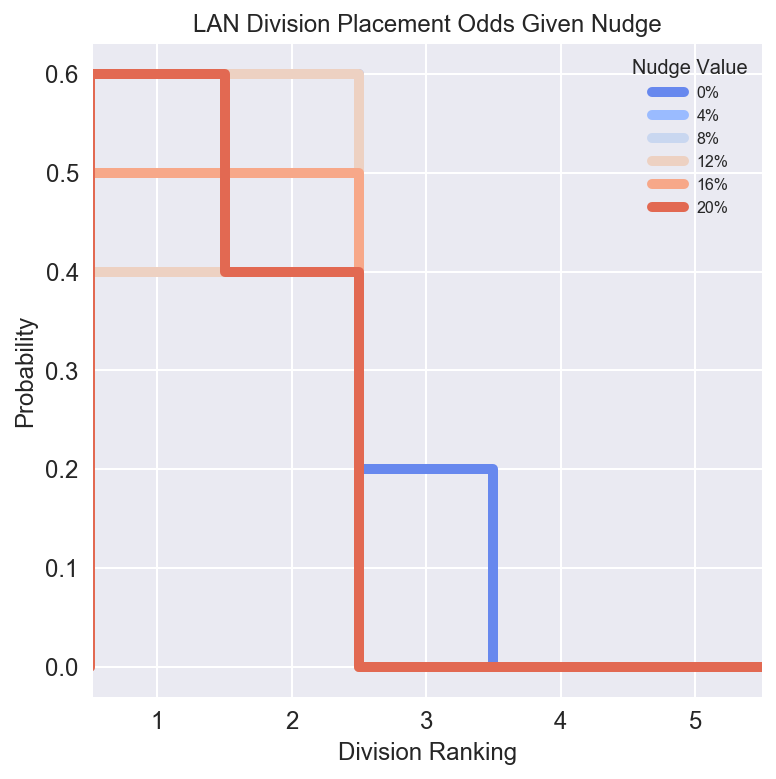

In [31]:
# Check change in probability of the Dodgers winning the division.  

# Set color palette
plt.figure(figsize=(6,6))
sns.set_palette(sns.color_palette("coolwarm",len(zero_sum_sims_LAD)))

nudge_team = 'LAN'
division_win_prob = {}
for inudge in nudge_vals:
    h = np.histogram(zero_sum_sims_LAD[inudge].standings['NL']['Division_Rank']['West'].loc[nudge_team]+1,bins = np.arange(7));
    division_win_prob[inudge] = h[0]/num_season_sims
    x =(h[1][1:]+h[1][:-1])/2 #- 0.5
    plt.step(x,division_win_prob[inudge], linewidth = 5,label=str(inudge))#,where='mid')
plt.xlim([0.52,5.5])
plt.xlabel('Division Ranking')
plt.ylabel('Probability');
plt.xticks([1,2,3,4,5]);
plt.title(nudge_team+' Division Placement Odds Given Nudge')
plt.legend([str(n)+'%' for n in nudge_vals],title='Nudge Value');
print("""
    The Dodgers's odds of winning the division rise from {0:.2f} to {1:.2f}.
    """.format(division_win_prob[nudge_vals[0]][1],division_win_prob[nudge_vals[-1]][1]) )
plt.savefig('dodgers_division_win_odds_2016.pdf')


    LA's average win totals remain around 92 +- 5.3 for all nudge levels. 
    


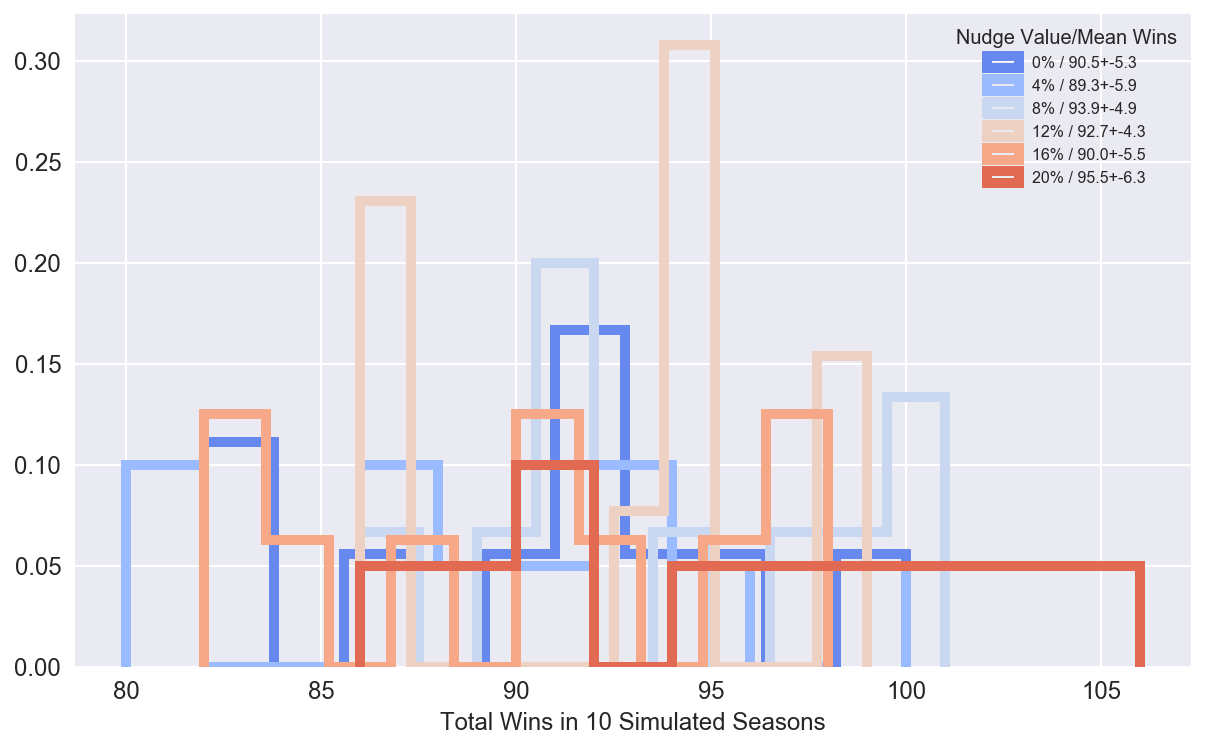

In [33]:
# Check that nudging is indeed a zero-sum effect by making sure total wins remains the same for different nudge levels. 
plt.figure(figsize=(8,7))
sns.set_palette(sns.color_palette("coolwarm",len(zero_sum_sims_LAD)))
ic = 0
avg_wins = {}
err_wins = {}
for inudge in nudge_vals:
    plt.hist(zero_sum_sims_LAD[inudge].standings['NL']['Division_Record']['West'].loc[nudge_team],histtype='step', density=True, linewidth = 5);
    avg_wins[inudge] = np.mean(zero_sum_sims_LAD[inudge].standings['NL']['Division_Record']['West'].loc[nudge_team])
    err_wins[inudge] = np.std(zero_sum_sims_LAD[inudge].standings['NL']['Division_Record']['West'].loc[nudge_team])
    ic+=1
plt.xlabel('Total Wins in {0} Simulated Seasons'.format(num_season_sims));
plt.legend(['{0}% / {1:.1f}+-{2:.1f}'.format(n, avg_wins[n],err_wins[n]) for n in nudge_vals],title='Nudge Value/Mean Wins');
print("""
    LA's average win totals remain around {0:0.0f} +- {1:0.1f} for all nudge levels. 
    """.format(np.median(zero_sum_sims_LAD[0].standings['NL']['Division_Record']['West'].loc[nudge_team]),np.std(zero_sum_sims_LAD[0].standings['NL']['Division_Record']['West'].loc[nudge_team]) ))


    LA's playoff odds rise 0%, from 0.90 to 0.90, which is roughly 
    similar to the odds of winning the division, which rise from 0.40 to 0.60. 
    Wildcard appearances, on the other hand, decrease as more divisions are won, but
    the net playoff appearances is nonetheless still positive.   
    


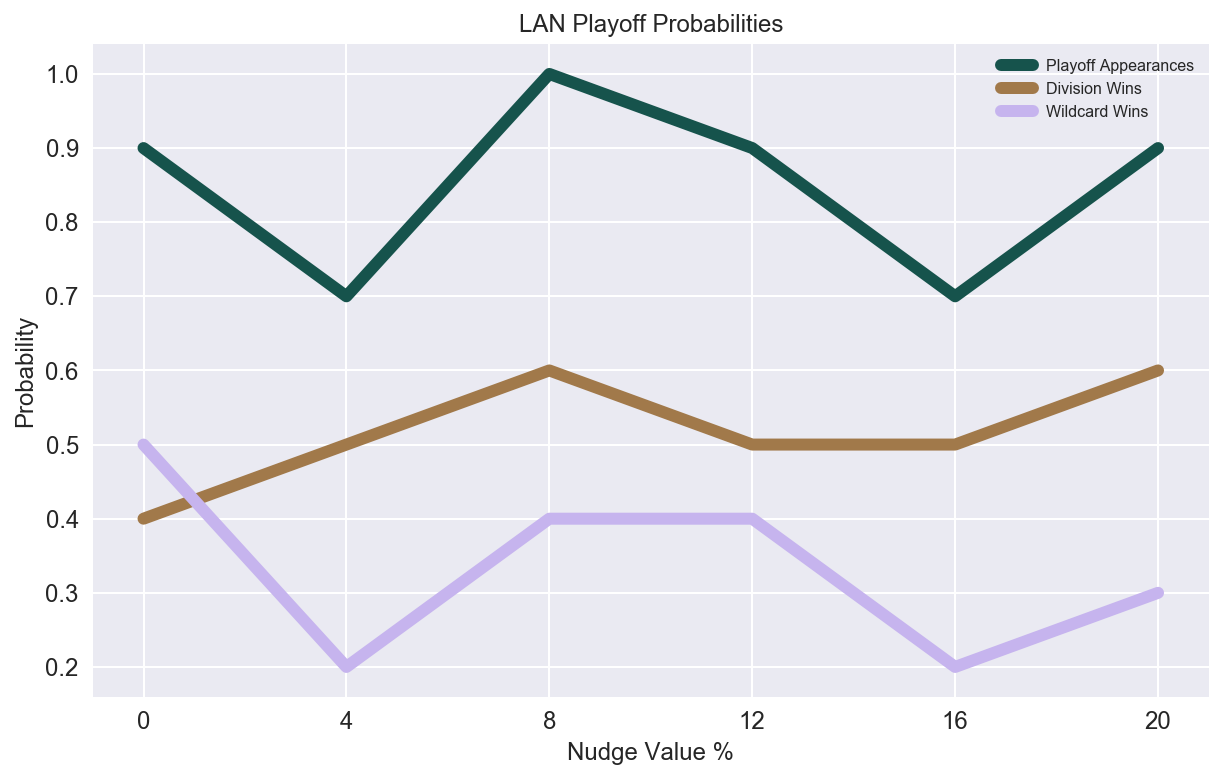

In [34]:
# Compare odds of making the playoff by winning the division or winning the wild card.
plt.figure(figsize=(10,6))
sns.set_palette(sns.color_palette("cubehelix", 3))
y_playoff_appearance = np.array([zero_sum_sims_LAD[i].playoff_appearances['NL'][nudge_team]/num_season_sims for i in nudge_vals])
y_division_wins = np.array([zero_sum_sims_LAD[i].division_wins['NL']['West'][nudge_team]/num_season_sims for i in nudge_vals])
y_wild_cards = y_playoff_appearance - y_division_wins

plt.plot(nudge_vals,y_playoff_appearance, linewidth = 6);
plt.plot(nudge_vals,y_division_wins, linewidth = 6);
plt.plot(nudge_vals,y_wild_cards, linewidth = 6);
plt.xlabel('Nudge Value %');
plt.ylabel('Probability');
plt.xticks(nudge_vals);
plt.legend(['Playoff Appearances', 'Division Wins', 'Wildcard Wins']);
plt.title(nudge_team+' Playoff Probabilities');
print("""
    LA's playoff odds rise {0:0.0f}%, from {1:.2f} to {2:.2f}, which is roughly 
    similar to the odds of winning the division, which rise from {3:.2f} to {4:.2f}. 
    Wildcard appearances, on the other hand, decrease as more divisions are won, but
    the net playoff appearances is nonetheless still positive.   
    """.format((y_playoff_appearance[-1]-y_playoff_appearance[0])*100,y_playoff_appearance[0],y_playoff_appearance[-1],y_division_wins[0],y_division_wins[-1]))


    LA's playoff odds go 0%, from 0.90 to 0.90, while the  
    odds of winning the division go from 0.40 to 0.60. 
    Wildcard appearances, on the other hand, decrease as more divisions are won, but
    the net playoff appearances is nonetheless still positive.   
    


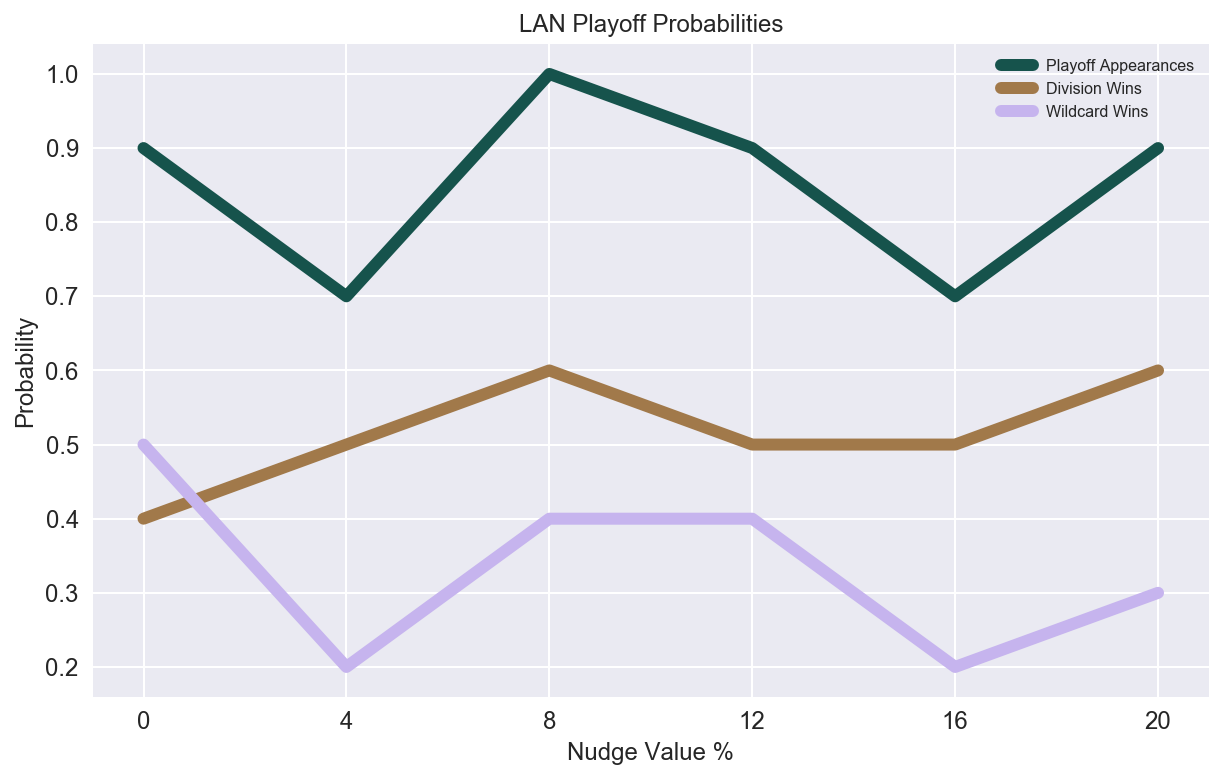

In [36]:
# Compare odds of making the playoff by winning the division or winning the wild card.
plt.figure(figsize=(10,6))
sns.set_palette(sns.color_palette("cubehelix", 3))
y_playoff_appearance = np.array([zero_sum_sims_LAD[i].playoff_appearances['NL'][nudge_team]/num_season_sims for i in nudge_vals])
y_division_wins = np.array([zero_sum_sims_LAD[i].division_wins['NL']['West'][nudge_team]/num_season_sims for i in nudge_vals])
y_wild_cards = y_playoff_appearance - y_division_wins

plt.plot(nudge_vals,y_playoff_appearance, linewidth = 6);
plt.plot(nudge_vals,y_division_wins, linewidth = 6);
plt.plot(nudge_vals,y_wild_cards, linewidth = 6);
plt.xlabel('Nudge Value %');
plt.ylabel('Probability');
plt.xticks(nudge_vals);
plt.legend(['Playoff Appearances', 'Division Wins', 'Wildcard Wins']);
plt.title(nudge_team+' Playoff Probabilities');
print("""
    LA's playoff odds go {0:0.0f}%, from {1:.2f} to {2:.2f}, while the  
    odds of winning the division go from {3:.2f} to {4:.2f}. 
    Wildcard appearances, on the other hand, decrease as more divisions are won, but
    the net playoff appearances is nonetheless still positive.   
    """.format((y_playoff_appearance[-1]-y_playoff_appearance[0])*100,y_playoff_appearance[0],y_playoff_appearance[-1],y_division_wins[0],y_division_wins[-1]))

/Users/marcoviero/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]



    LA's playoff odds rise from 0.89 to 0.89, at the expense of San Francisco and Colorado, which drop 
    from 0.66 to 0.58, and 0.04, respectively. 
    


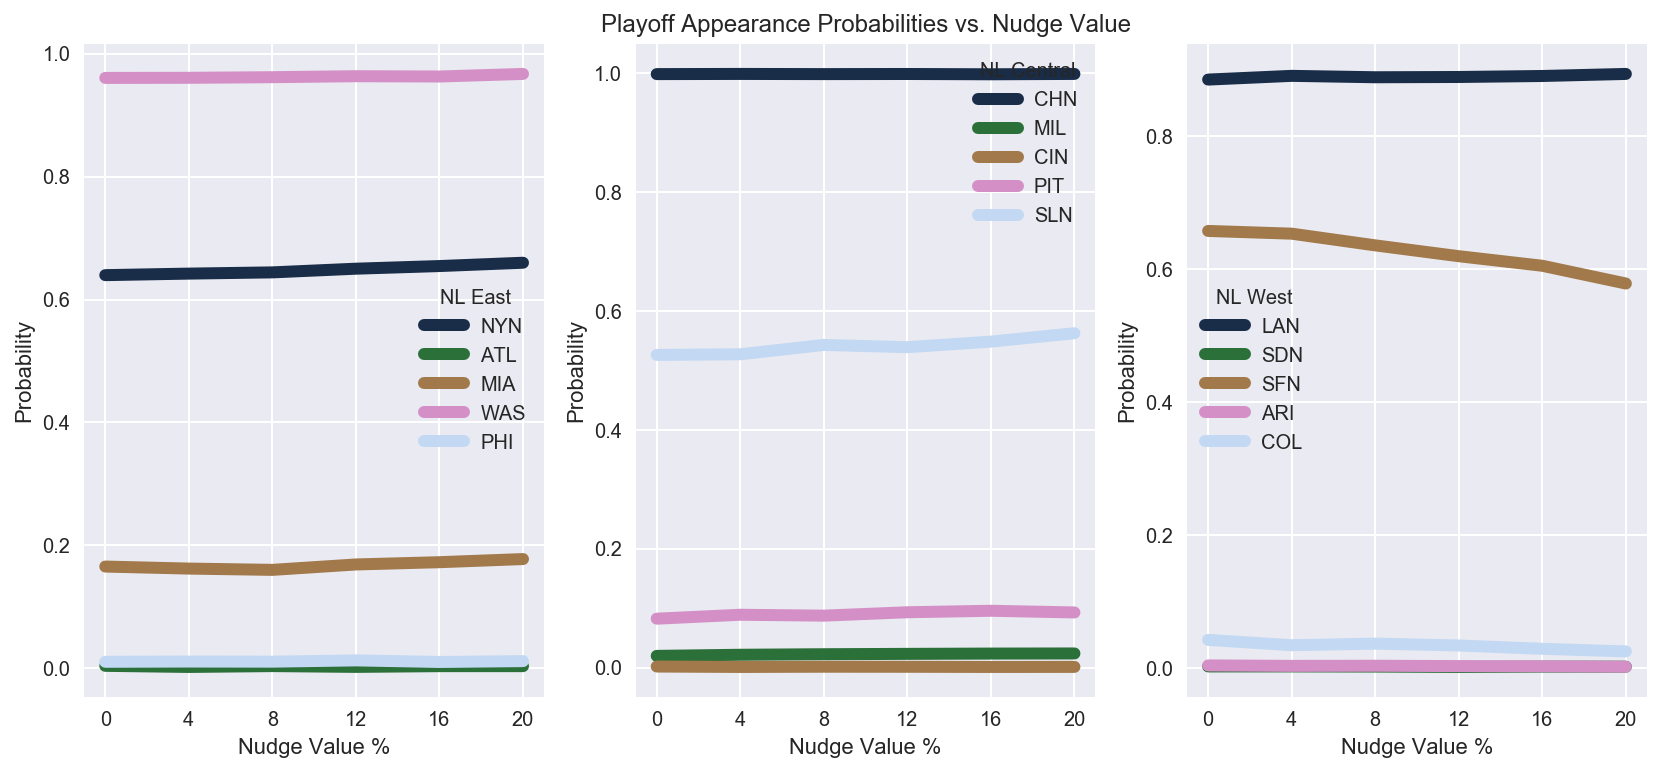

In [54]:
plt.figure(figsize=(14,6))
div_col= {'East':sns.color_palette("cubehelix", 5),
           'Central':sns.color_palette("cubehelix", 5),
           'West':sns.color_palette("cubehelix", 5)}
linestyle = ['-','--',':']
playoff_appearance_probability = {}
Lg = 'NL'
j=131
for divsn in zero_sum_sims_LAD[0].leagues[Lg]:
    color = div_col[divsn]
    k = 0
    for iteam in zero_sum_sims_LAD[0].leagues[Lg][divsn]:
        plt.subplot(j)
        playoff_appearance_probability[iteam] = np.array([zero_sum_sims_LAD[i].playoff_appearances[Lg][iteam]/num_season_sims for i in nudge_vals])
        plt.plot(nudge_vals,playoff_appearance_probability[iteam], linewidth = 6, color=color[k][:], label=iteam);
        k += 1
    j += 1
    plt.xlabel('Nudge Value %');
    plt.ylabel('Probability');
    plt.xticks(nudge_vals);
    plt.legend(title = Lg+' '+divsn);
    if j == 133: plt.title('Playoff Appearance Probabilities vs. Nudge Value');
print("""
    LA's playoff odds rise from {0:.2f} to {1:.2f}, at the expense of San Francisco and Colorado, which drop 
    from {2:.2f} to {3:.2f}, and {4:.2f}, respectively. 
    """.format(playoff_appearance_probability['LAN'][0],playoff_appearance_probability['LAN'][-1],
              playoff_appearance_probability['SFN'][0],playoff_appearance_probability['SFN'][-1],
              playoff_appearance_probability['COL'][0],playoff_appearance_probability['COL'][-1],
              playoff_appearance_probability['ARI'][0],playoff_appearance_probability['ARI'][-1],
              playoff_appearance_probability['SDN'][0],playoff_appearance_probability['SDN'][-1]))

# Winning Percentage vs WAR

In [3]:
from pybaseball import pitching_stats
from pybaseball import schedule_and_record
from pybaseball import playerid_lookup
from pybaseball import statcast_pitcher
import datetime

In [4]:
# Hard-code Dictionary of Team Names
team_dict = {'Yankees':'NYA','Blue Jays':'TOR','Red Sox':'BOS','Orioles':'BAL','Rays':'TBA',
             'White Sox':'CWS','Royals':'KCA','Indians':'CLE','Twins':'MIN','Tigers':'DET',
             'Athletics':'OAK','Angels':'ANA','Astros':'HOU','Rangers':'TEX','Mariners':'SEA',
             'Mets':'NYN','Braves':'ATL','Marlins':'MIA','Nationals':'WAS','Phillies':'PHI',
             'Cubs':'CHN','Brewers':'MIL','Reds':'CIN','Pirates':'PIT','Cardinals':'SLN',
             'Dodgers':'LAD','Padres':'SDN','Giants':'SFN','Diamondbacks':'ARI','Rockies':'COL'}

In [5]:
def home_win_probability(ht_truetalent, vt_truetalent, homefieldadv = 0.04, ht_nudge = 0.0, vt_nudge = 0.0):
    ''' Estimate win or loss based on combination of true talent of both teams, and random chance. '''

    # Effective True Talent can be nudged up or down if say, starting pitcher is the ace, or sitting best players for rest.
    eff_ht = ht_truetalent * (1 + ht_nudge + homefieldadv);
    eff_vt = vt_truetalent * (1 + vt_nudge);

    # Combine effective weights (plus home field advantage) with team true talents to estimate effective probabililty.
    return (eff_ht * (1 - eff_vt)) / ((eff_ht * (1 - eff_vt)) + (eff_vt * (1 - eff_ht)))

In [13]:
# Define Simple Fitting Functions
def linear_w_war(w, a, b):
    return a * w + b
def parabola_w_war(w, a, b): #, c):
    return a * w + b * w ** 2 + 0.5
def exp_w_war(w, a, b, c):
    return a * np.exp(-1*w/b) + c

In [ ]:
wp_war_season = {}
war_depth = 3 #0 #40
n_seasons = 2 #12
seasons = [2019] - np.arange(n_seasons)
show_progress = False
for iseason in seasons:
    #if show_progress == True:
    print(iseason)
    opponent_record = {}
    pitching_df = pitching_stats(iseason)
    year_dates = [str(iseason)+'-01-01', str(iseason)+'-12-31']
    pitching_war = pitching_df[['Name','WAR','Team']]
    # PWP - Player Winning Percentage
    # NWP - Team Winning Percentage without Pitcher
    # TWP - Team Winning Percentage
    # EWP - Estimated Team Winning Percentage in Pitchers Games without Pitcher.  
    # BWP - Biased Winning Percentage
    wp_war = pd.DataFrame(columns = ['Name','GS','IP','WAR','TWP','PWP','NWP','EWP','BWP1','BWP2','BWP3'])
    for iptc in np.arange(0,war_depth):
        pitcher = pitching_war.iloc[iptc]
        if show_progress == True:
            print(pitcher.Name)
        pitcher_name = pitcher.Name.split()
        #try: 
        if (pitcher_name[1] != 'Gonzales') & (pitcher_name[1] != 'Diaz') & (pitcher_name[1] != 'Carrasco') & (pitcher_name[1] != 'Wheeler') & (pitcher_name[1] != 'Castillo') & (pitcher_name[1] != 'Stroman'):
            war = pitcher.WAR
            if show_progress == True:
                print(war)

            # Get pitchers mlbam id number
            pitcher_bio = playerid_lookup(pitcher_name[-1],pitcher_name[0])
            key_mlbam = pitcher_bio.key_mlbam.values[-1]

            # Get pitcher start dates.  Limit to regular season.
            pitcher_stats = statcast_pitcher(year_dates[0],year_dates[1],key_mlbam)
            pitcher_stats = pitcher_stats.loc[pitcher_stats['game_type'] == 'R',]
            pitcher_starts_dates = pitcher_stats.groupby('game_pk').last()                       
            pitcher_starts  = len(pitcher_stats.groupby(['game_date']).first().inning)
            pitcher_innings = pitcher_stats.groupby(['game_date']).first().inning.sum()
            if show_progress == True:
                print('''{0} Innings over {1} Starts'''.format(pitcher_innings, pitcher_starts))
            
            # Find pitcher team
            pitcher_team = team_dict[pitcher.Team] 
            if show_progress == True:
                print(pitcher_team)
            if pitcher_team == 'WSH' or pitcher_team == 'WAS':
                pitcher_team = 'WSN'
            if pitcher_team == 'CWS':
                pitcher_team = 'CHA'        

            # Get team record
            sched_df = schedule_and_record(iseason,pitcher_team);

            # Cast dates to YYYY-mm-dd
            dates = []
            for d in sched_df.Date.values:
                if '(' in d:
                    l = d.find('(')
                    r = d.find(')')
                    d = d[:l]+d[r+1:]
                dates.append(datetime.datetime.strptime(d + ' ' + str(iseason), '%A, %b %d %Y').strftime('%Y-%m-%d'))
            pitcher_starts  = len(pitcher_stats.groupby(['game_date']).first().inning)
            pitcher_innings = pitcher_stats.groupby(['game_date']).first().inning.sum()
            
            # Locate dates in schedule that pitcher appears
            idx_games = [dates.index(i) for i in pitcher_starts_dates.game_date.values]
            
            # Calculate team winning percentage of season, and when pitcher appears
            pitcher_result = sched_df.iloc[idx_games]['W/L'] # Team Record of games with Pitcher
            no_pitcher_result = sched_df.iloc[[i not in (idx_games) for i in range(len(sched_df))]]['W/L'] # Team Record of games without Pitcher
            team_result = sched_df['W/L'] # Entire Team Season Record
            win_percent_pitcher = np.sum(['W' in i for i in pitcher_result.values])/len(pitcher_result)
            win_percent_no_pitcher = np.sum(['W' in i for i in no_pitcher_result.values])/len(no_pitcher_result)
            win_percent_team_0 = np.sum(['W' in i for i in team_result.values])/len(team_result)
            if show_progress == True:
                print('''{0:.3f} - Win % in Games Pitched'''.format(win_percent_pitcher))
                print('''{0:.3f} - Win % in Games NOT Pitched'''.format(win_percent_no_pitcher))
                print('''{0:.3f} - Win % for ALL Games'''.format(win_percent_team_0))           
            
            # Estimate expected pitcher record accounting for strength of both teams
            win_percent_in = win_percent_no_pitcher
            estimated_record_0 = []
            estimated_record_1 = []
            estimated_record_2 = []
            estimated_record_3 = []
            for itm in range(len(idx_games)):
                otm = sched_df.iloc[idx_games[itm]]['Opp']
                h_a = sched_df.iloc[idx_games[itm]]['Home_Away']
                if otm not in opponent_record:
                    sar = schedule_and_record(iseason,otm);
                    team_result = sar['W/L']
                    opponent_record[otm] = team_result
                win_percent_team = np.sum(['W' in i for i in opponent_record[otm].values])/len(opponent_record[otm])
                
                # Choose bias values of the WAR to set as nudge factors
                bias = [.01,.03,.05]
                if h_a == 'Home':
                    estimated_record_0.append(home_win_probability(win_percent_in, win_percent_team))
                    estimated_record_1.append(home_win_probability(win_percent_in, win_percent_team, ht_nudge = bias[0]*war)) 
                    estimated_record_2.append(home_win_probability(win_percent_in, win_percent_team, ht_nudge = bias[1]*war)) 
                    estimated_record_3.append(home_win_probability(win_percent_in, win_percent_team, ht_nudge = bias[2]*war)) 
                else:
                    estimated_record_0.append(1-home_win_probability(win_percent_team, win_percent_in))
                    estimated_record_1.append(1-home_win_probability(win_percent_team, win_percent_in, vt_nudge = bias[0]*war)) 
                    estimated_record_2.append(1-home_win_probability(win_percent_team, win_percent_in, vt_nudge = bias[1]*war)) 
                    estimated_record_3.append(1-home_win_probability(win_percent_team, win_percent_in, vt_nudge = bias[2]*war)) 
                    
            # Report Resulting Winning Percentages
            if show_progress == True:
                print('''{0:.3f} - Estimated Team Win %'''.format(np.mean(estimated_record_0)))
                print('''{0:.3f} - Estimated w/ Nudge {1:.2f} * WAR ({2:.2f}%) '''.format(np.mean(estimated_record_1),bias[0],bias[0]*war))
                print('''{0:.3f} - Estimated w/ Nudge {1:.2f} * WAR ({2:.2f}%) '''.format(np.mean(estimated_record_2),bias[1],bias[1]*war))
                print('''{0:.3f} - Estimated w/ Nudge {1:.2f} * WAR ({2:.2f}%) '''.format(np.mean(estimated_record_3),bias[2],bias[2]*war))
            
            # Add pitcher to output 
            wp_war = wp_war.append(pd.Series([pitcher.Name,pitcher_starts,pitcher_innings,pitcher.WAR,win_percent_team_0,win_percent_pitcher,win_percent_no_pitcher,np.mean(estimated_record_0),np.mean(estimated_record_1),np.mean(estimated_record_2),np.mean(estimated_record_3)],index=wp_war.columns),ignore_index=True)
            if show_progress == True:
                print(pitcher.Name+' success!') 
        #except:
        else:
            if show_progress == True:
                print('No '+pitcher.Name) 
    wp_war_season[iseason] = wp_war

2019


In [9]:
# Combine years into one DataFrame
years = wp_war_season.keys()
i=0
for y in years:
    print(y)
    if i == 0:
        wp_war_all = wp_war_season[y]
    else:
        wp_war_all = wp_war_all.append(wp_war_season[y])
    i+=1
wp_war_all = wp_war_all.dropna()

2019
2018


In [10]:
wp_war_all.head()

,Name,GS,IP,WAR,TWP,PWP,NWP,EWP,BWP1,BWP2,BWP3
0,Gerrit Cole,33,215,7.4,0.660494,0.787879,0.627907,0.644034,0.688869,0.779095,0.870572
1,Jacob deGrom,32,206,7.0,0.530864,0.437500,0.553846,0.555844,0.593438,0.669351,0.746593
2,Lance Lynn,33,212,6.8,0.481481,0.515152,0.472868,0.453620,0.484111,0.545825,0.608769
0,Jacob deGrom,32,219,9.0,0.475309,0.437500,0.484615,0.470154,0.512712,0.599053,0.687378
1,Max Scherzer,33,222,7.5,0.506173,0.696970,0.457364,0.472417,0.505702,0.572248,0.638939


In [19]:
war_bins = np.arange(3,9,0.5).tolist()
war_bins[-1] = 9
binned_df = wp_war_all.copy()
binned_df['WAR_BINS'] = pd.cut(x=wp_war_all['WAR'], bins=war_bins)
WAR = binned_df.groupby('WAR_BINS').median().dropna().WAR
WIN = binned_df.groupby('WAR_BINS').mean().dropna().PWP
WIN1 = binned_df.groupby('WAR_BINS').mean().dropna().BWP1.values
WIN2 = binned_df.groupby('WAR_BINS').mean().dropna().BWP2.values
WIN3 = binned_df.groupby('WAR_BINS').mean().dropna().BWP3.values
average_pitcher_war = 1.5

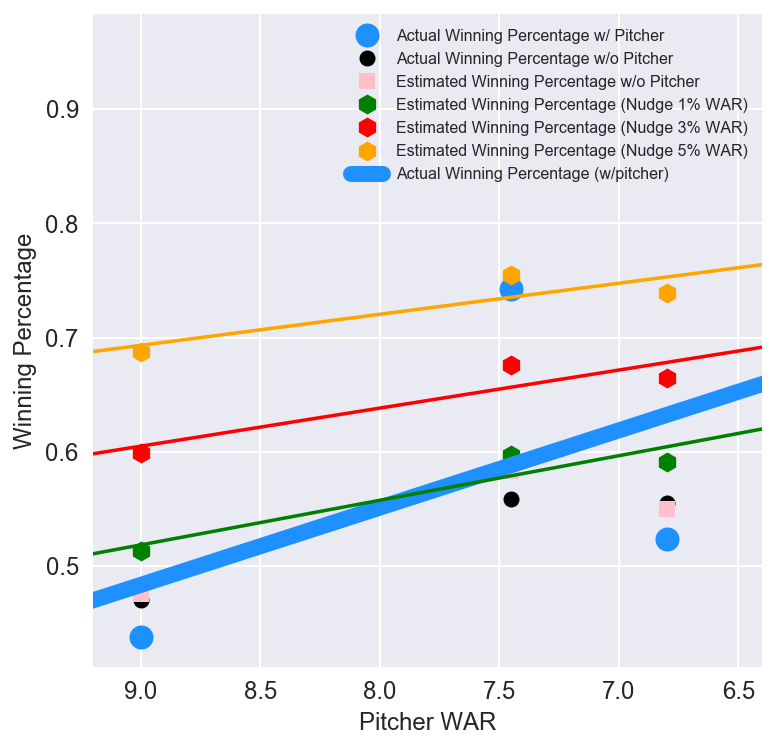

In [21]:
plt.figure(figsize=(6,6))
sns.set_palette(sns.color_palette("colorblind", 4))
plt.plot(WAR, binned_df.groupby('WAR_BINS').mean().dropna().PWP,'o',color='dodgerblue',ms=12,label='Actual Winning Percentage w/ Pitcher')
plt.plot(WAR, binned_df.groupby('WAR_BINS').mean().dropna().EWP,'o',color='black',ms=8,label='Actual Winning Percentage w/o Pitcher')
plt.plot(WAR, binned_df.groupby('WAR_BINS').mean().dropna().TWP,'s',color='pink',ms=8,label='Estimated Winning Percentage w/o Pitcher')
plt.plot(WAR, binned_df.groupby('WAR_BINS').mean().dropna().BWP1,'h',color='green',ms=10,label='Estimated Winning Percentage (Nudge 1% WAR)')
plt.plot(WAR, binned_df.groupby('WAR_BINS').mean().dropna().BWP2,'h',color='red',ms=10,label='Estimated Winning Percentage (Nudge 3% WAR)')
plt.plot(WAR, binned_df.groupby('WAR_BINS').mean().dropna().BWP3,'h',color='orange',ms=10,label='Estimated Winning Percentage (Nudge 5% WAR)')
plt.xlim(np.max(wp_war_all.WAR)+.2, np.min(wp_war_all.WAR)-.2)
plt.xlabel('Pitcher WAR'); plt.ylabel('Winning Percentage');

war_mod = np.arange(2,10,0.5)
p_lin, cov_lin = curve_fit(linear_w_war, WAR, WIN)
p_lin1, cov_lin = curve_fit(linear_w_war, WAR, WIN1)
p_lin2, cov_lin = curve_fit(linear_w_war, WAR, WIN2)
p_lin3, cov_lin = curve_fit(linear_w_war, WAR, WIN3)
y = linear_w_war(war_mod, p_lin[0], p_lin[1])

def parabola_w_war(w, a, b): #, c):
    return a * w + b * w ** 2 + 0.5
p = linear_w_war(war_mod, p_lin[0], p_lin[1])#, p_par[2])
p1 = linear_w_war(war_mod, p_lin1[0], p_lin1[1])#, p_par1[2])
p2 = linear_w_war(war_mod, p_lin2[0], p_lin2[1])#, p_par2[2])
p3 = linear_w_war(war_mod, p_lin3[0], p_lin3[1])#, p_par3[2])
#plt.plot(war_mod,y,color='dodgerblue')
plt.plot(war_mod,p,color='dodgerblue',lw=8,label='Actual Winning Percentage (w/pitcher)')
plt.plot(war_mod,p1,color='green');
plt.plot(war_mod,p2,color='red');
plt.plot(war_mod,p3,color='orange');
plt.legend();

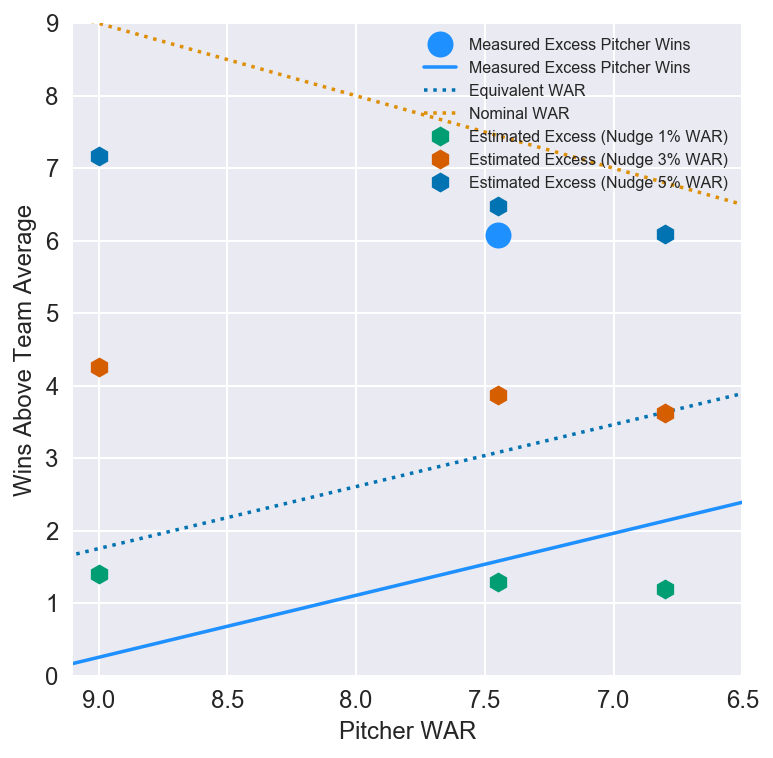

In [22]:
plt.figure(figsize=(6,6))

#def parabola_w_war(w, a, b, c):
#    return a * w + b * w ** 2 + c
N_starts = np.mean(binned_df.groupby('GS').mean().index) 
sns.set_palette(sns.color_palette("colorblind", 4))
WAR = binned_df.groupby('WAR_BINS').median().dropna().WAR
WARM = N_starts * (binned_df.groupby('WAR_BINS').mean().dropna().PWP-binned_df.groupby('WAR_BINS').mean().dropna().EWP)

p_lin, cov_lin = curve_fit(linear_w_war, WAR, WARM)
p_exp, cov_exp = curve_fit(parabola_w_war, WAR, WARM)
plt.plot(WAR, WARM,'o',color='dodgerblue',ms=13,label='Measured Excess Pitcher Wins')

xl = [np.max(wp_war_all.WAR)+.1, np.min(wp_war_all.WAR)-.1]
yl = [0,9]
plt.xlim(xl)
plt.ylim(yl)
plt.xlabel('Pitcher WAR'); plt.ylabel('Wins Above Team Average');

war_mod = np.arange(3,10,0.5)
y = linear_w_war(war_mod, p_lin[0], p_lin[1])
plt.plot(war_mod,y,color='dodgerblue',label='Measured Excess Pitcher Wins')
plt.plot(war_mod,y+average_pitcher_war,':',label='Equivalent WAR')
plt.plot(xl,xl,':',label='Nominal WAR')

WARM1 = N_starts * (binned_df.groupby('WAR_BINS').mean().dropna().BWP1-binned_df.groupby('WAR_BINS').mean().dropna().EWP)
WARM2 = N_starts * (binned_df.groupby('WAR_BINS').mean().dropna().BWP2-binned_df.groupby('WAR_BINS').mean().dropna().EWP)
WARM3 = N_starts * (binned_df.groupby('WAR_BINS').mean().dropna().BWP3-binned_df.groupby('WAR_BINS').mean().dropna().EWP)
plt.plot(binned_df.groupby('WAR_BINS').median().dropna().WAR, WARM1,'h',ms=10,label='Estimated Excess (Nudge 1% WAR)')
plt.plot(binned_df.groupby('WAR_BINS').median().dropna().WAR, WARM2,'h',ms=10,label='Estimated Excess (Nudge 3% WAR)')
plt.plot(binned_df.groupby('WAR_BINS').median().dropna().WAR, WARM3,'h',ms=10,label='Estimated Excess (Nudge 5% WAR)')
plt.legend();